In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import json
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch  # Add this import
from scipy.ndimage import gaussian_filter1d

# Set style for all plots
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': [8.0, 6.0],
    'figure.dpi': 300,
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white'
})


In [2]:
 # Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Setup paths
scratch_dir = os.getenv("SCRATCH_DIR")

In [3]:
# %%
# Base directory for analysis outputs
OUTPUT_DIR = Path(scratch_dir) / "output"
SAVE_DIR = Path(OUTPUT_DIR) / "final_figures"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# Groups and their data paths
GROUPS = ['affair', 'paranoia', 'combined']

# Colors for plotting
COLORS = {
    'affair': '#e41a1c',      # Red
    'affair_light': '#ff6666', # Light red
    'paranoia': '#4daf4a',    # Green
    'paranoia_light': '#90ee90', # Light green
    'combined': '#984ea3',    # Purple
    'combined_light': '#d8b2d8' # Light purple
}

In [4]:
SAVE_DIR_FIG3 = Path(SAVE_DIR) / "figure3"
SAVE_DIR_FIG3.mkdir(parents=True, exist_ok=True)

In [5]:
def plot_brain_state_effects(main_analysis, use_cohens_d=True, save_path=None):
    """Create figure showing content feature effects with consistent metrics
    
    Parameters:
    -----------
    main_analysis : numpy.ndarray or dict
        Array containing the analysis results data structure
    use_cohens_d : bool
        If True, use standardized effect size as x-axis metric; if False, use log odds coefficients
    save_path : str, optional
        Path to save the figure
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The generated figure with brain state effects plots
    """
    # Convert numpy array to dictionary
    if isinstance(main_analysis, np.ndarray):
        results_dict = main_analysis.item()
    else:
        results_dict = main_analysis
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Get features from the feature_results dictionary
    features = list(results_dict['feature_results'].keys())
    
    # Sort features by absolute effect magnitude
    if use_cohens_d:
        # Sort by standardized effect
        plot_features = sorted(
            features, 
            key=lambda f: abs(results_dict['effect_sizes'][f]['standardized_effect']),
            reverse=True
        )
    else:
        # Sort by coefficient magnitude
        plot_features = sorted(
            features, 
            key=lambda f: abs(results_dict['feature_results'][f]['coefficients']['group']),
            reverse=True
        )
    
    # Prepare data for Affair group
    affair_data = {
        'feature': plot_features
    }
    
    # Use either standardized effect or log odds ratio based on parameter
    if use_cohens_d:
        # For standardized effect, use the values from effect_sizes
        affair_data['effect'] = [results_dict['effect_sizes'][f]['standardized_effect'] for f in plot_features]
        x_label = "Effect Size (Standardized)"
    else:
        # For log odds ratio, use the odds_ratio values
        affair_data['effect'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['odds_ratio']) for f in plot_features]
        x_label = "Log Odds Ratio"
    
    # Add credible intervals and probability
    if use_cohens_d:
        # Use HDI for standardized effect
        affair_data['ci_lower'] = [results_dict['feature_results'][f]['hdi']['group']['lower'] for f in plot_features]
        affair_data['ci_upper'] = [results_dict['feature_results'][f]['hdi']['group']['upper'] for f in plot_features]
    else:
        # For log odds ratio, transform the HDI to log scale
        affair_data['ci_lower'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['lower']) for f in plot_features]
        affair_data['ci_upper'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['upper']) for f in plot_features]
    
    # Use posterior_prob instead of prob_nonzero
    affair_data['probability'] = [results_dict['feature_results'][f]['posterior_prob']['group'] for f in plot_features]
    
    # Prepare data for Paranoia group (effect + interaction)
    paranoia_data = {
        'feature': plot_features
    }
    
    # Get combined effects for paranoia group
    if use_cohens_d:
        # This is approximate since we don't have direct standardized effect for combined effects
        paranoia_data['effect'] = [results_dict['effect_sizes'][f]['standardized_effect'] * 
                                (1 + results_dict['feature_results'][f]['coefficients']['interaction'] / 
                                results_dict['feature_results'][f]['coefficients']['group'])
                                for f in plot_features]
    else:
        # For log odds ratio, calculate combined effect (group + interaction)
        paranoia_data['effect'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['odds_ratio'] * 
                                   results_dict['feature_results'][f]['odds_ratios']['interaction']['odds_ratio'])
                                   for f in plot_features]
    
    # Add credible intervals and probability for paranoia
    if use_cohens_d:
        # For paranoia with standardized effect, we need to add the HDIs
        paranoia_data['ci_lower'] = [results_dict['feature_results'][f]['hdi']['group']['lower'] +
                                    results_dict['feature_results'][f]['hdi']['interaction']['lower']
                                    for f in plot_features]
        paranoia_data['ci_upper'] = [results_dict['feature_results'][f]['hdi']['group']['upper'] +
                                    results_dict['feature_results'][f]['hdi']['interaction']['upper']
                                    for f in plot_features]
    else:
        # For log odds ratio, calculate the combined CI for group + interaction
        # This is an approximation using the product of the odds ratios
        paranoia_data['ci_lower'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['lower'] * 
                                         results_dict['feature_results'][f]['odds_ratios']['interaction']['lower'])
                                     for f in plot_features]
        paranoia_data['ci_upper'] = [np.log(results_dict['feature_results'][f]['odds_ratios']['group']['upper'] * 
                                         results_dict['feature_results'][f]['odds_ratios']['interaction']['upper'])
                                     for f in plot_features]
    
    paranoia_data['probability'] = [results_dict['feature_results'][f]['posterior_prob']['interaction'] 
                                    for f in plot_features]
    
    # Convert to DataFrames
    df_affair = pd.DataFrame(affair_data)
    df_paranoia = pd.DataFrame(paranoia_data)
    
    # Define group colors
    affair_color = COLORS['affair']    # Red
    paranoia_color = COLORS['paranoia']  # Blue
    
    # Helper function for color adjustment
    def adjust_color_alpha(color, alpha_factor):
        """Adjust the alpha/intensity of a color"""
        rgb = plt.cm.colors.ColorConverter.to_rgb(color)
        return tuple([c * alpha_factor + (1-alpha_factor) for c in rgb])
    
    # Function to plot one group
    def plot_group(ax, df, title, group_color):
        # Create color variants for probability levels
        color_high = group_color
        color_med = adjust_color_alpha(group_color, 0.7)
        color_low = adjust_color_alpha(group_color, 0.4)
        gray_color = '#777777'
        
        # Determine color based on posterior probability AND CI crossing zero
        colors = []
        for _, row in df.iterrows():
            # Check if CI crosses zero - stricter condition
            ci_crosses_zero = (row['ci_lower'] < 0 and row['ci_upper'] > 0)
            
            # Get the appropriate probability value
            prob = row['probability']
            
            # Print debug info
            # print(f"Feature: {row['feature']}, Effect: {row['effect']:.4f}, CI: [{row['ci_lower']:.4f}, {row['ci_upper']:.4f}], Prob: {prob:.4f}, CI crosses 0: {ci_crosses_zero}")
            
            # Only assign probability color if CI doesn't cross zero
            if not ci_crosses_zero:
                if prob > 0.999:
                    colors.append(color_high)
                elif prob > 0.99:
                    colors.append(color_med)  
                elif prob > 0.95:
                    colors.append(color_low)
                else:
                    colors.append(gray_color)
            else:
                colors.append(gray_color)
        
        # Calculate y-positions
        y_pos = np.arange(len(df))
        
        # Find appropriate axis limits
        all_values = list(df['effect']) + list(df['ci_lower']) + list(df['ci_upper'])
        min_val = min(all_values)
        max_val = max(all_values)
        
        # Add padding
        padding = 0.1 * (max_val - min_val)
        x_min = min_val - padding
        x_max = max_val + padding
        
        # Ensure zero is visible if it's close to the range
        if min_val > -padding and min_val < 0:
            x_min = -padding
        if max_val < padding and max_val > 0:
            x_max = padding
            
        # Plot reference line at zero
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
        
        # Plot data points and intervals
        for i, (_, row) in enumerate(df.iterrows()):
            # Plot CI line
            ax.hlines(y=y_pos[i], xmin=row['ci_lower'], xmax=row['ci_upper'], 
                     color=colors[i], alpha=0.6, linewidth=2.5)
            
            # Plot point
            ax.scatter(row['effect'], y_pos[i], color=colors[i], s=80, zorder=3)
        
        # Set axis labels
        ax.set_yticks(y_pos)
        ax.set_yticklabels([f.replace('_', ' ').title() for f in df['feature']], fontsize=10)
        ax.set_xlabel(x_label, fontsize=12)
        ax.set_title(title, fontsize=14)
        
        # Set axis limits
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(-0.5, len(df) - 0.5)
        
        # Add grid
        ax.grid(axis='x', linestyle=':', alpha=0.3)
        
        # Add legend with only elements that appear in the plot
        from matplotlib.lines import Line2D
        
        # Create sets to track which probability levels are used
        has_high_prob = any(c == color_high for c in colors)
        has_med_prob = any(c == color_med for c in colors)
        has_low_prob = any(c == color_low for c in colors)
        has_gray = any(c == gray_color for c in colors)
        
        # Only include legend elements that are present in the plot
        legend_elements = []
        if has_high_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_high,
                                label='>99.9% probability', markersize=8))
        if has_med_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_med,
                                label='>99% probability', markersize=8))
        if has_low_prob:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_low,
                                label='>95% probability', markersize=8))
        if has_gray:
            legend_elements.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=gray_color,
                                label='<95% probability or CI crosses 0', markersize=8))
        
        # Only add legend if there are elements to show
        if legend_elements:
            ax.legend(handles=legend_elements, loc='best', fontsize=8)
    
    # Plot both groups
    plot_group(ax1, df_affair, 'Affair Group Effects', affair_color)
    plot_group(ax2, df_paranoia, 'Paranoia Group Effects', paranoia_color)
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    if save_path:
        plt.savefig(SAVE_DIR_FIG3 / f'{save_path}.png', dpi=300, bbox_inches='tight')
        plt.savefig(SAVE_DIR_FIG3 / f'{save_path}.svg', dpi=300, bbox_inches='tight')
    
    return fig

In [6]:
state_map = {"affair_to_paranoia": {0:1, 1:2, 2:0}, "paranoia_to_affair": {1:0, 2:1, 0:2}}

In [7]:
def get_brain_content_data(state_affair, state_paranoia):
    # Use Path.glob() method instead of glob module
    pattern = f'hierarchical_analysis_results_*.npz'
    search_path = Path(OUTPUT_DIR) / '11_brain_content_analysis' / f'state_affair_{state_affair}_state_paranoia_{state_paranoia}'
    brain_content_path = list(search_path.glob(pattern))[0]
    brain_content_data = np.load(brain_content_path, allow_pickle=True)
    meta_data = brain_content_data['metadata']
    main_analysis = brain_content_data['main_analysis']
    cross_validation = brain_content_data['cross_validation']
    return meta_data, main_analysis, cross_validation

In [8]:
state_affair = 0
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a0p1 , main_analysis_a0p1, cross_validation_a0p1 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 1
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a1p2, main_analysis_a1p2, cross_validation_a1p2 = get_brain_content_data(state_affair, state_paranoia)
state_affair = 2
state_paranoia = state_map["affair_to_paranoia"][state_affair]
meta_data_a2p0, main_analysis_a2p0, cross_validation_a2p0 = get_brain_content_data(state_affair, state_paranoia)

In [9]:
main_analysis_a0p1

array({'feature_results': {'lee_girl_together': {'coefficients': {'const': -0.40784340721856427, 'feature': 0.1413536787620091, 'group': 0.11735168396385152, 'interaction': 0.027448048017093378}, 'posterior_sds': {'const': 0.128457428120713, 'feature': 0.10430092553284913, 'group': 0.03282607858832412, 'interaction': 0.14696808178618437}, 'posterior_prob': {'const': 0.9992506380502552, 'feature': 0.9123308104513761, 'group': 0.9998248545064311, 'interaction': 0.5740763658829201}, 'prob_positive': {'const': 0.0007493619497448423, 'feature': 0.9123308104513761, 'group': 0.9998248545064311, 'interaction': 0.5740763658829201}, 'prob_negative': {'const': 0.9992506380502552, 'feature': 0.08766918954862385, 'group': 0.00017514549356887073, 'interaction': 0.4259236341170799}, 'hdi': {'const': {'lower': -0.6596153398818045, 'upper': -0.156071474555324}, 'feature': {'lower': -0.06307237883656933, 'upper': 0.34577973636058756}, 'group': {'lower': 0.053013752177054826, 'upper': 0.18168961575064824

In [10]:
main_analysis_a2p0

array({'feature_results': {'lee_girl_together': {'coefficients': {'const': -0.8171601158774245, 'feature': 0.17761942192822863, 'group': -0.1566120375822237, 'interaction': -0.11559991902878741}, 'posterior_sds': {'const': 0.10512211687242962, 'feature': 0.10701076209258831, 'group': 0.03490907573802892, 'interaction': 0.15462906198869786}, 'posterior_prob': {'const': 0.9999999999999962, 'feature': 0.9515254353424492, 'group': 0.999996376198656, 'interaction': 0.7726477698316209}, 'prob_positive': {'const': 3.774758283725532e-15, 'feature': 0.9515254353424492, 'group': 3.623801343999311e-06, 'interaction': 0.22735223016837913}, 'prob_negative': {'const': 0.9999999999999962, 'feature': 0.04847456465755086, 'group': 0.999996376198656, 'interaction': 0.7726477698316209}, 'hdi': {'const': {'lower': -1.023195678925997, 'upper': -0.6111245528288521}, 'feature': {'lower': -0.03211781773142852, 'upper': 0.3873566615878858}, 'group': {'lower': -0.2250325687623414, 'upper': -0.088191506402106}, 

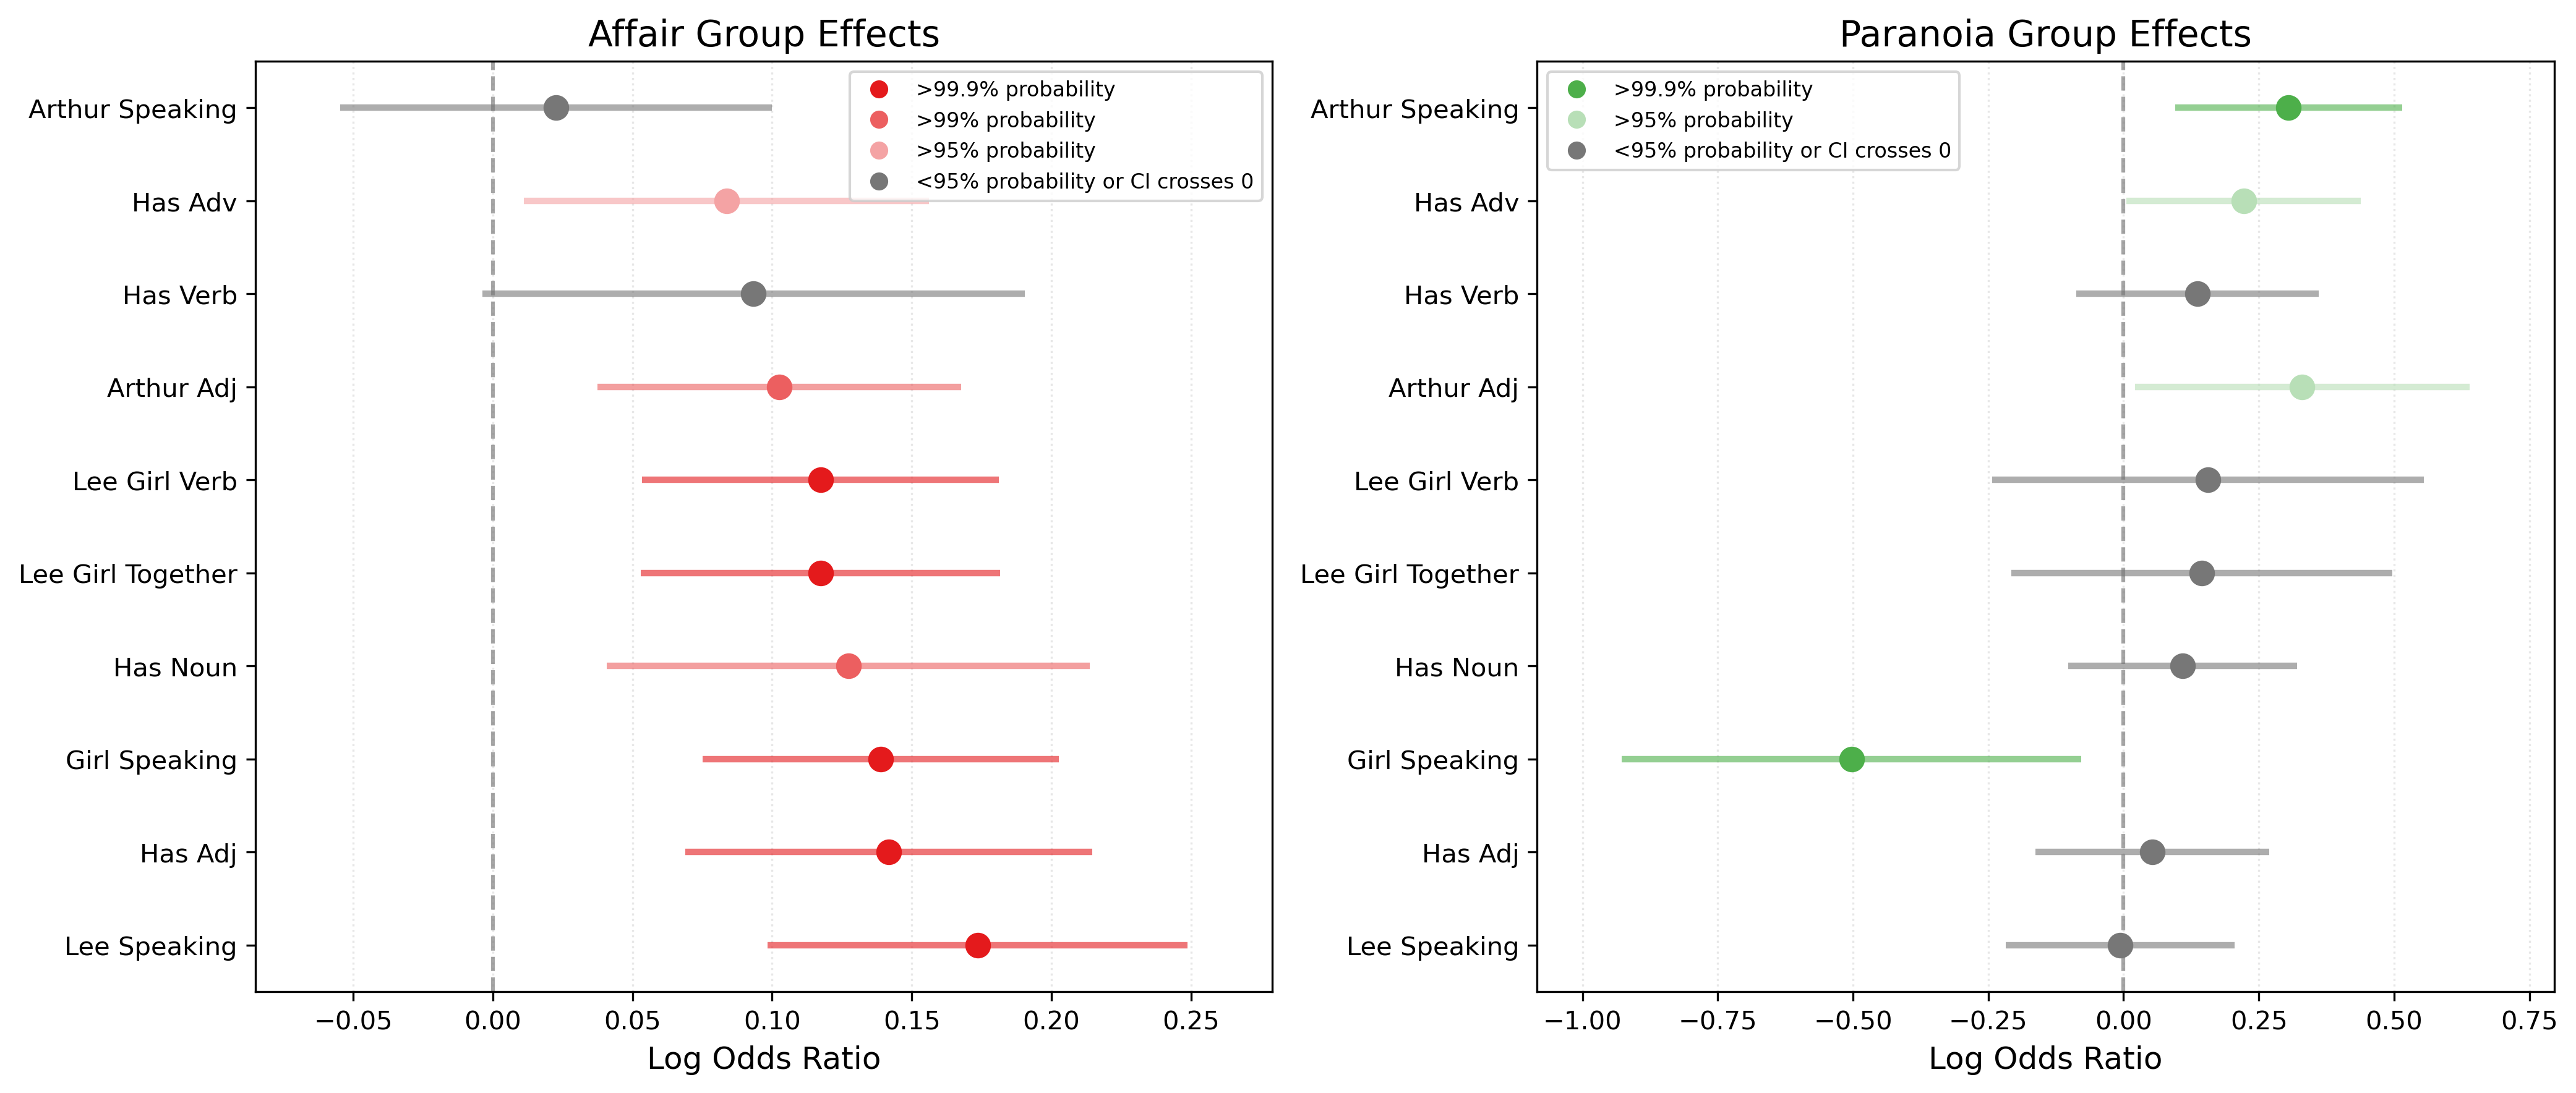

In [11]:
plot_brain_state_effects(main_analysis_a0p1, use_cohens_d=False, save_path='glmm_treeplot_a0p1')

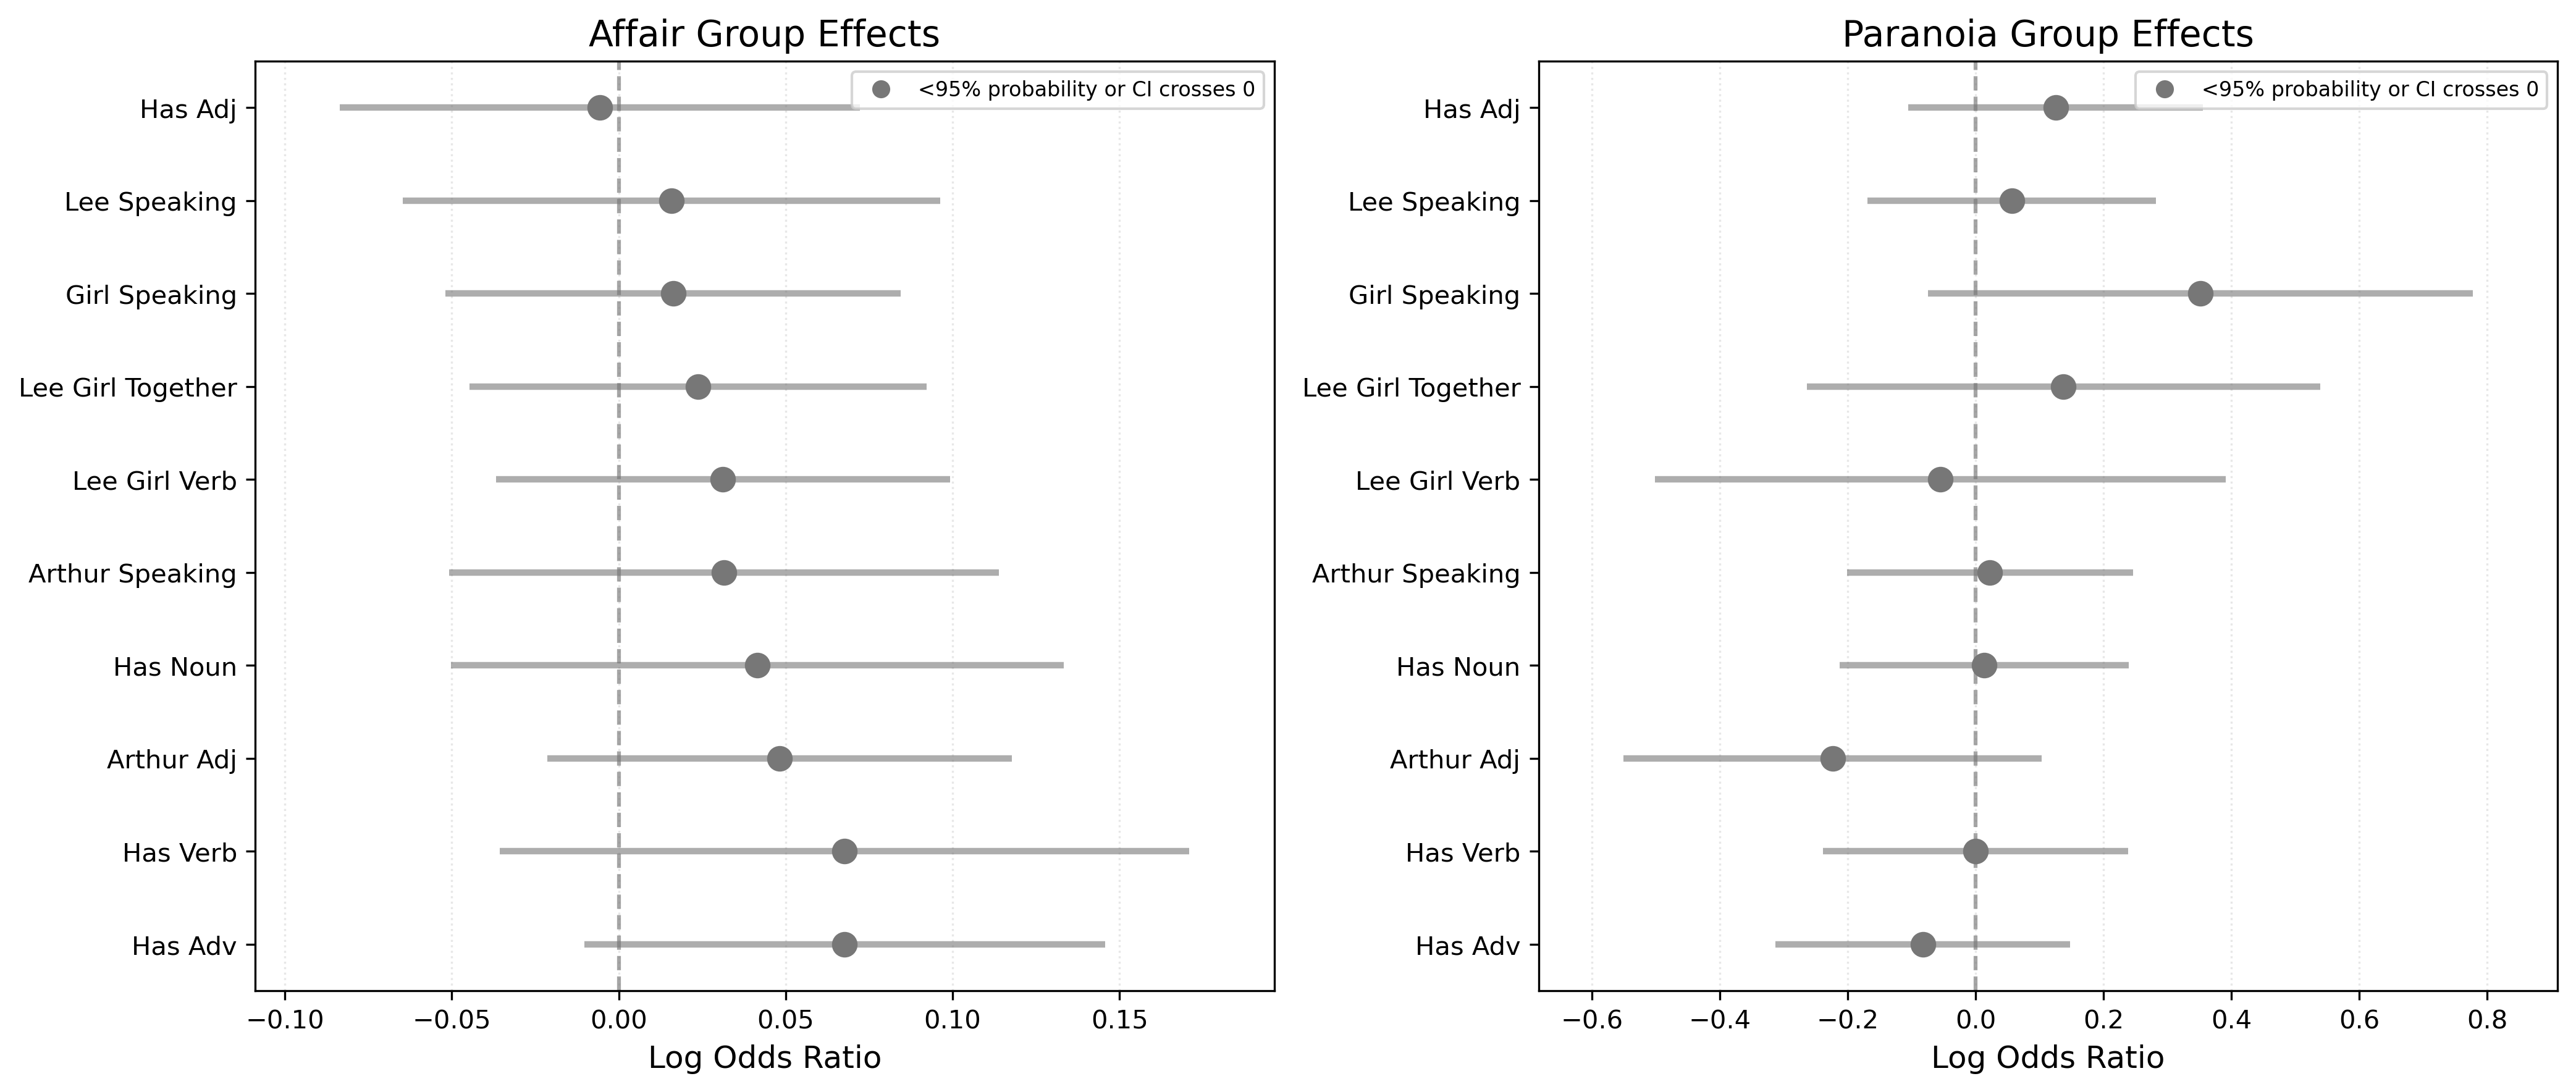

In [12]:
plot_brain_state_effects(main_analysis_a1p2, use_cohens_d=False, save_path='glmm_treeplot_a1p2')

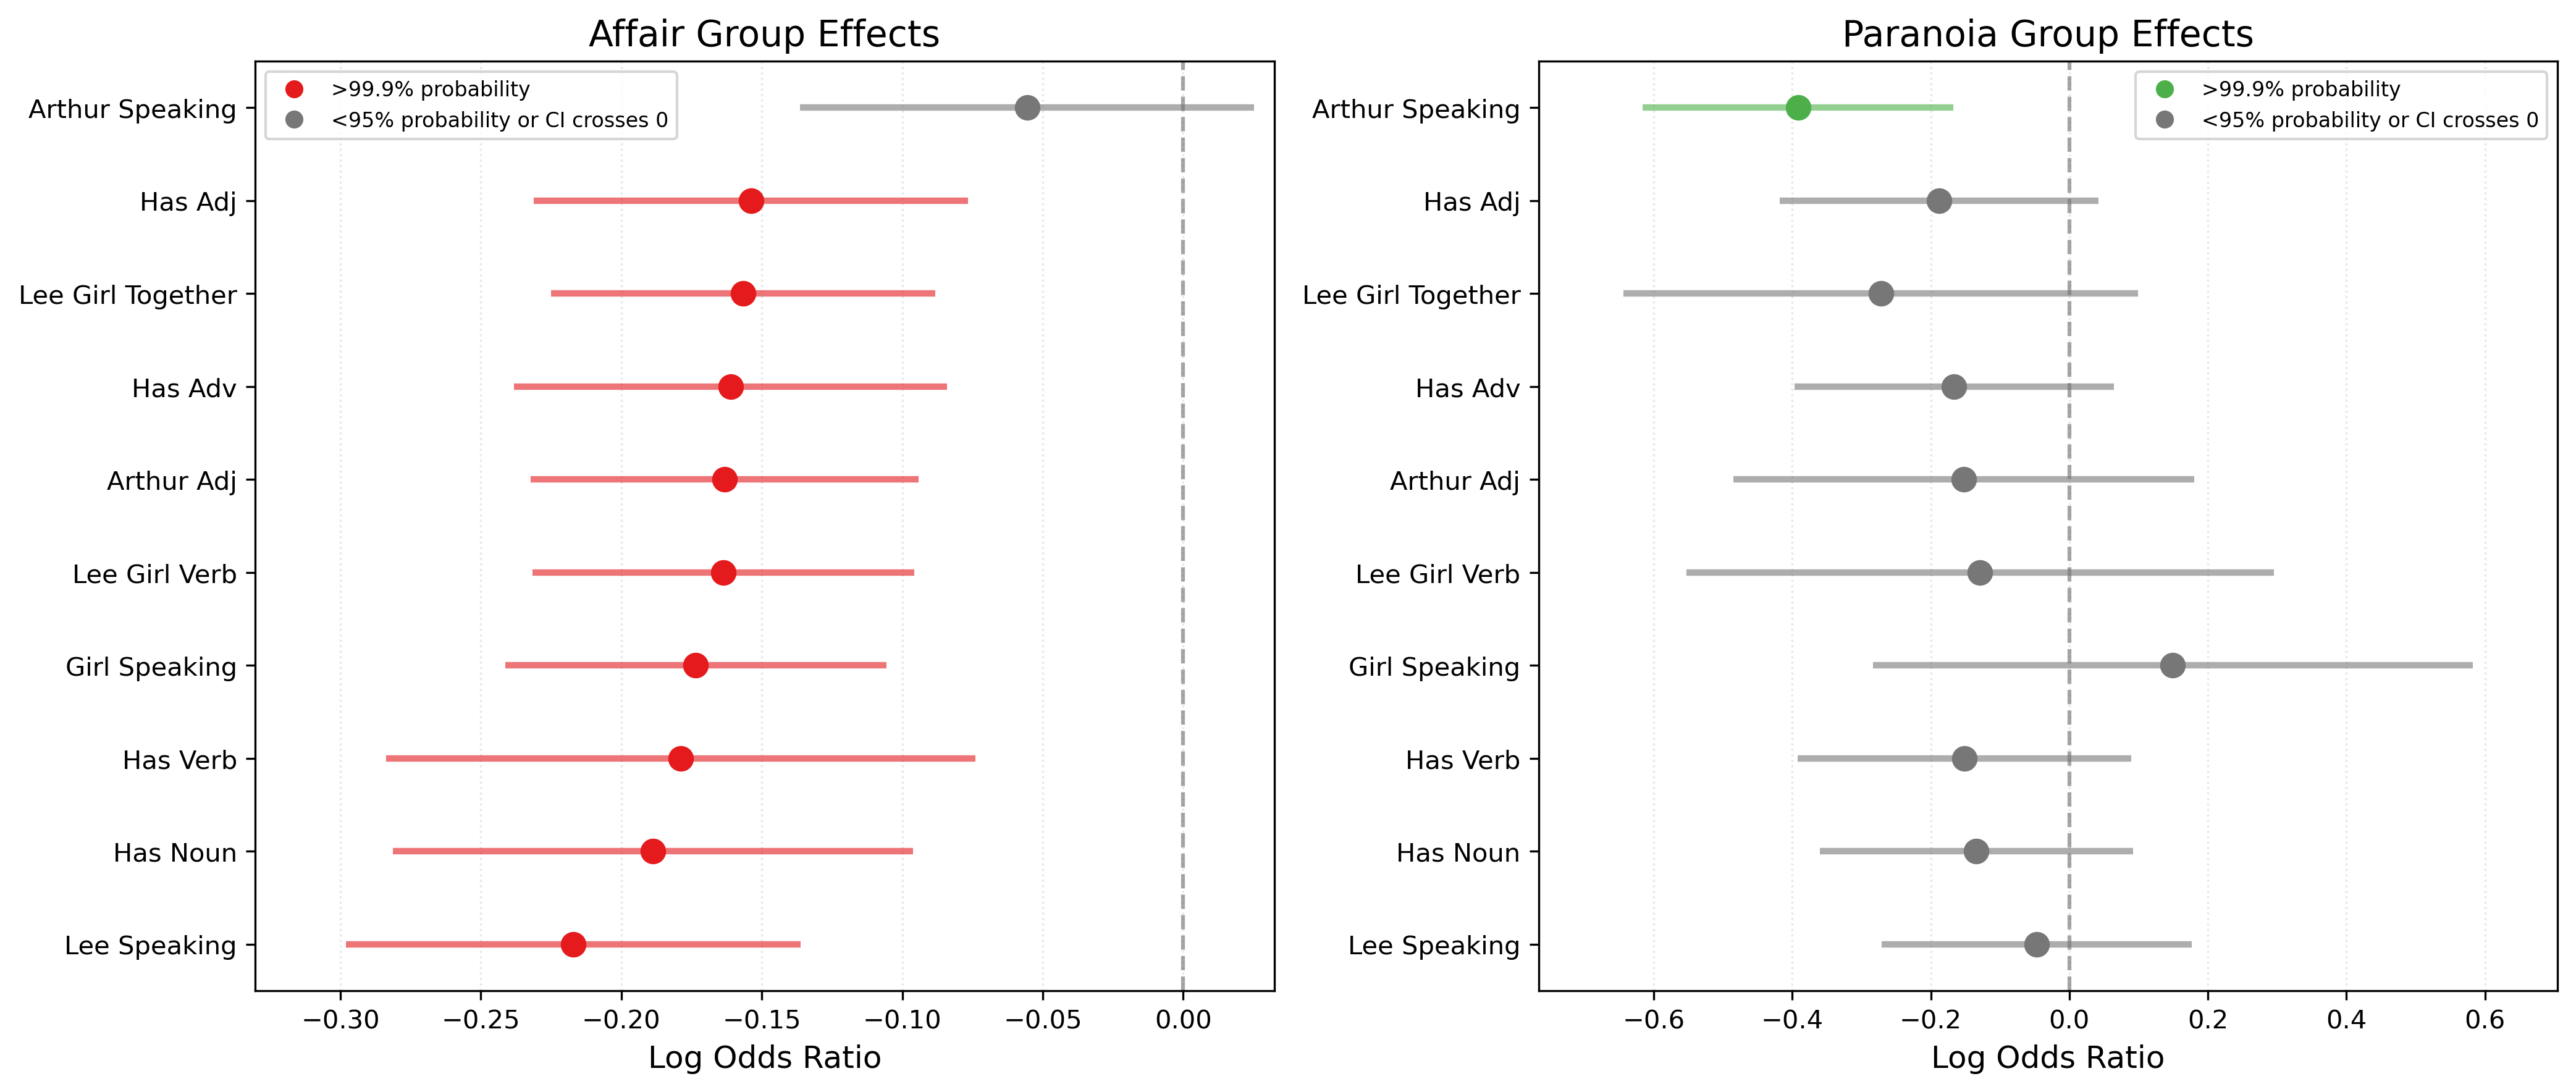

In [13]:
plot_brain_state_effects(main_analysis_a2p0, use_cohens_d=False, save_path='glmm_treeplot_a2p0')